In [4]:
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount("/content/drive")
# !unzip '/content/drive/MyDrive/Projects/CodeClause Projects/Age and Gender Detection System/UTKFace.zip'
!unzip '/content/drive/MyDrive/archive/UTKFace.zip'
# !unzip -q /content/drive/MyDrive/archive1.zip/UTKFace -d data
# !unzip -q /content/drive/MyDrive/Datasets/utkface_23k.zip -d data
# !mv data/utkface_23k data/utkface23k

Mounted at /content/drive
unzip:  cannot find or open /content/drive/MyDrive/archive/UTKFace.zip, /content/drive/MyDrive/archive/UTKFace.zip.zip or /content/drive/MyDrive/archive/UTKFace.zip.ZIP.


# New Section

In [6]:
BASE_DIR = '/content/drive/MyDrive/archive/UTKFace'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
    image_path = os.path.join(BASE_DIR, image)
    img_components = image.split('_')
    age_label = int(img_components[0])
    gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
    age_labels.append(age_label)
    gender_labels.append(gender_label)
    image_paths.append(image_path)

  0%|          | 0/6657 [00:00<?, ?it/s]

In [7]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 6657, Number of gender_labels: 6657, Number of image_paths: 6657


In [8]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [9]:
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,/content/drive/MyDrive/archive/UTKFace/26_0_1_...,26,0
1,/content/drive/MyDrive/archive/UTKFace/1_0_3_2...,1,0
2,/content/drive/MyDrive/archive/UTKFace/24_1_0_...,24,1
3,/content/drive/MyDrive/archive/UTKFace/25_1_0_...,25,1
4,/content/drive/MyDrive/archive/UTKFace/1_1_2_2...,1,1


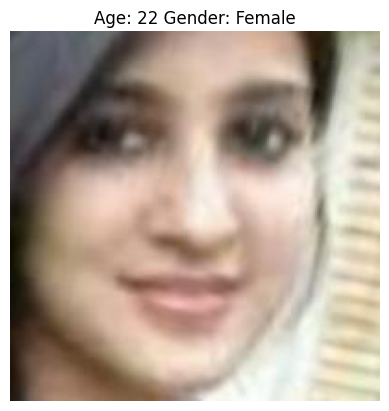

In [10]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

<Axes: xlabel='age', ylabel='Density'>

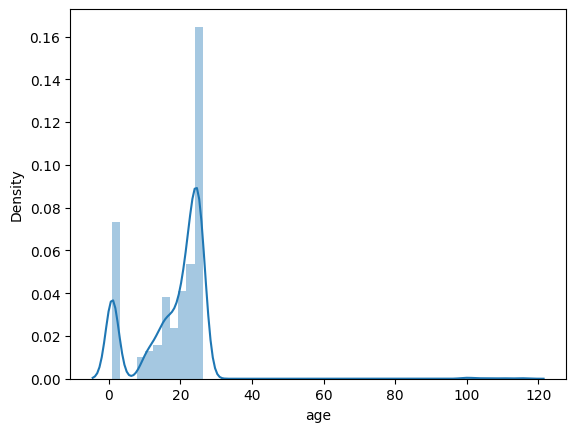

In [11]:
# Age distribution
sns.distplot(df['age'])

<Axes: ylabel='count'>

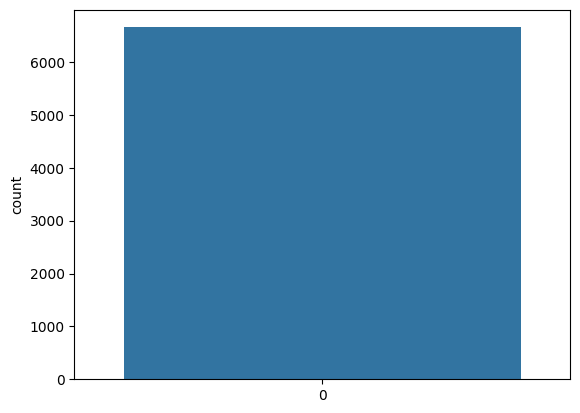

In [12]:
sns.countplot(df['gender'])

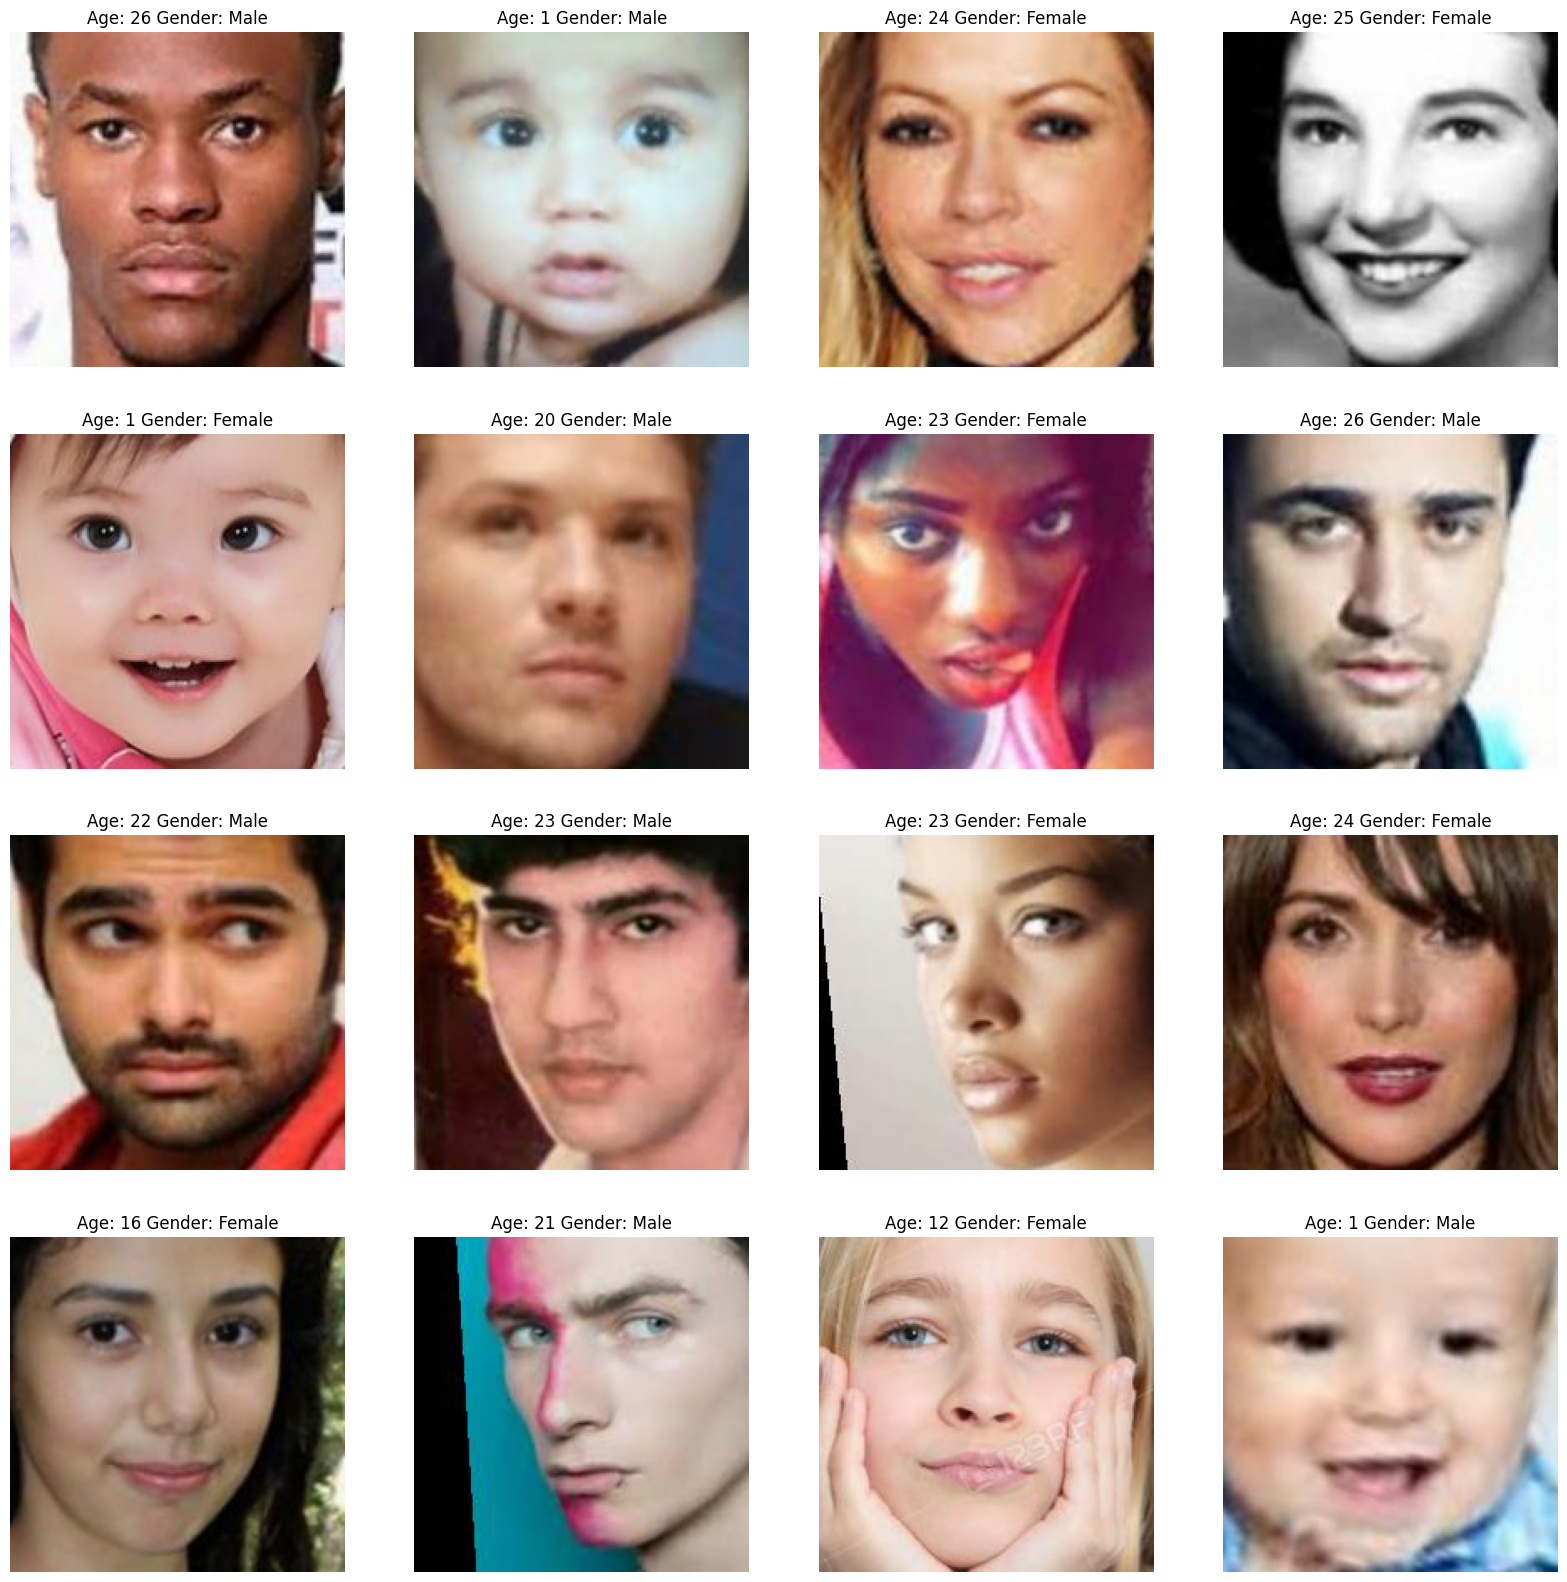

In [13]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

In [14]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [15]:
X = extract_image_features(df['image_path'])

  0%|          | 0/6657 [00:00<?, ?it/s]

In [16]:
X.shape

(6657, 128, 128, 1)

In [17]:
X = X / 255.0

In [18]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [19]:
input_shape = (128, 128, 1)

In [20]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy'])

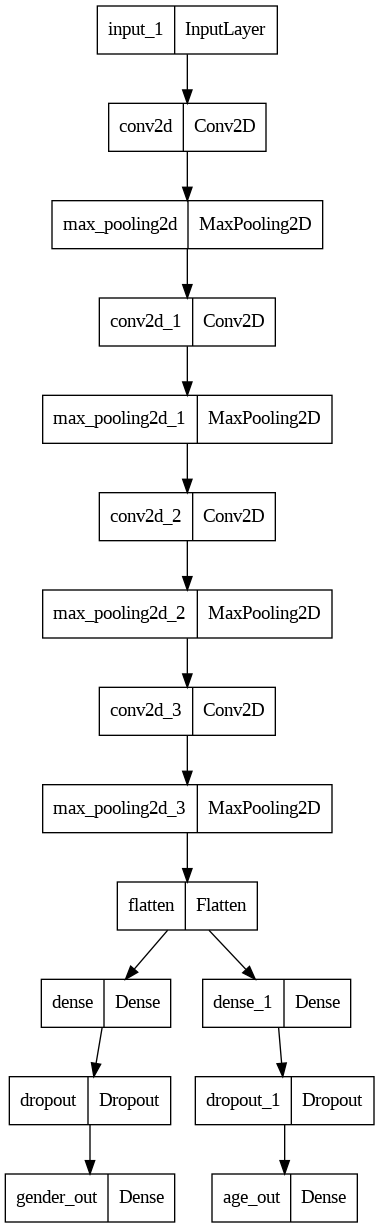

In [21]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [22]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
167/167 [==============================] - 17s 26ms/step - loss: 9.0423 - gender_out_loss: 0.7105 - age_out_loss: 8.3318 - gender_out_accuracy: 0.5119 - age_out_accuracy: 0.1679 - val_loss: 6.8271 - val_gender_out_loss: 0.6894 - val_age_out_loss: 6.1376 - val_gender_out_accuracy: 0.5045 - val_age_out_accuracy: 0.1674
Epoch 2/20
167/167 [==============================] - 4s 22ms/step - loss: 7.0526 - gender_out_loss: 0.6680 - age_out_loss: 6.3846 - gender_out_accuracy: 0.5962 - age_out_accuracy: 0.1690 - val_loss: 5.6562 - val_gender_out_loss: 0.6197 - val_age_out_loss: 5.0365 - val_gender_out_accuracy: 0.6719 - val_age_out_accuracy: 0.1674
Epoch 3/20
167/167 [==============================] - 5s 30ms/step - loss: 5.7052 - gender_out_loss: 0.6021 - age_out_loss: 5.1032 - gender_out_accuracy: 0.6734 - age_out_accuracy: 0.1472 - val_loss: 5.0336 - val_gender_out_loss: 0.5530 - val_age_out_loss: 4.4807 - val_gender_out_accuracy: 0.7087 - val_age_out_accuracy: 0.1276
Epoch 4/20
1

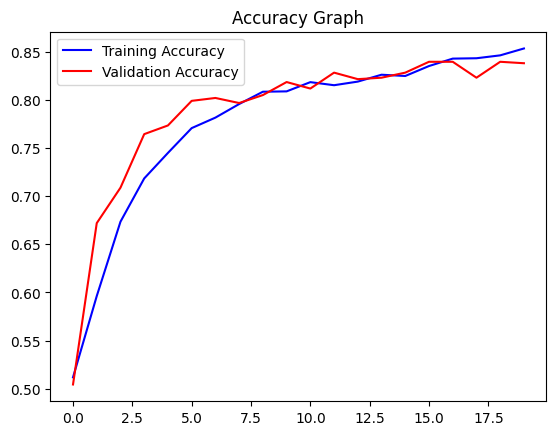

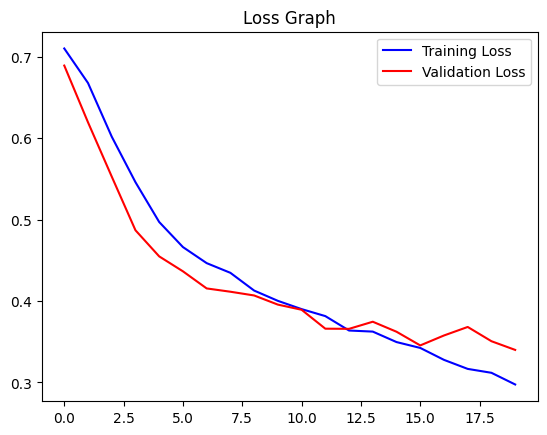

In [23]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

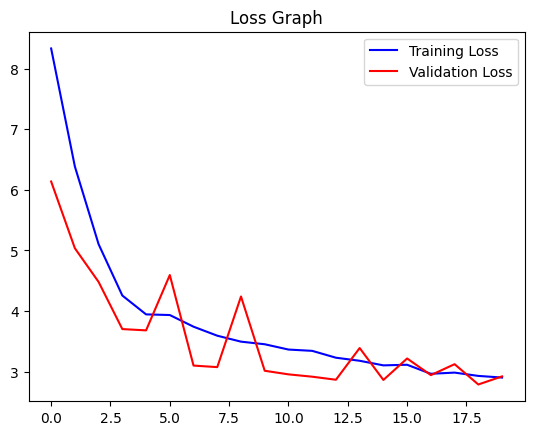

In [24]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


In [25]:
def get_image_features(image):
  img = load_img(image, grayscale=True)
  img = img.resize((128, 128), Image.ANTIALIAS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 18ms/step


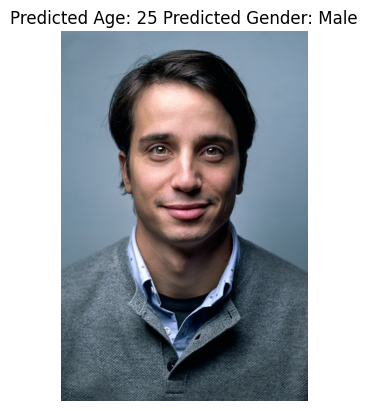

In [32]:
from google.colab import drive
drive.mount('/content/drive')
img_to_test = '/content/drive/MyDrive/testimg/testimg4.jpg'
features = get_image_features(img_to_test)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))